## Ocean Wind Field Classification Using CNNs and Sentinel-1 Level-2 OCN

<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/eopf-toolkit/eopf-101&branch=main&urlpath=lab/tree/eopf-101/submission.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

Sentinel-1 Level-2 Ocean (OCN) products provide reliable measurements of ocean surface wind speed and direction derived from Synthetic Aperture Radar (SAR). Because SAR can operate day and night and is unaffected by clouds, it offers consistent wind information even during periods of poor weather when optical sensors cannot observe the sea surface. This makes Sentinel-1 OCN data especially useful for marine monitoring and operational ocean applications.

The North Sea is known for rapidly changing wind conditions influenced by strong Atlantic weather systems. These winds impact maritime transport, offshore energy installations, and coastal safety. In this workflow, we analyze Sentinel-1 OCN wind-field scenes collected between February and October 2025 over the North Sea (1°–8°E, 51°–55°N), covering both storm-prone winter conditions and calmer summer periods.

In this notebook, we demonstrate how to access wind-field data from the EOPF STAC, preprocess it into standardized inputs, and train a Convolutional Neural Network (CNN) to classify ocean wind conditions into three categories: Calm, Moderate, and High Wind. The workflow provides a simple example of using SAR-derived wind information for automated ocean wind state classification.

### What we will learn

- 🌊 Understand how to access and explore Sentinel-1 Level-2 OCN wind-field data through the EOPF STAC interface.
- ⚒️ Prepare and transform geospatial wind datasets into machine-learning-ready inputs using Python and xarray.
- 🛰️ Train and evaluate a Convolutional Neural Network (CNN) to classify ocean wind regimes into Calm, Moderate, and High categories.

### Prerequisites

You should be familiar with basic Python, NumPy-style array processing, and geospatial data concepts.
This tutorial uses xarray, pystac-client, PyTorch, scikit-learn, and common plotting libraries.

<hr>

#### Installing libraries

In [1]:
!pip install seaborn torch scikit-learn -q

#### Import libraries

In [ ]:
import random
import numpy as np
from shapely.geometry import box
import requests
import xarray as xr
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


<hr>

## Configuration Parameters

Define the key settings for the workflow, including the STAC API endpoint, time range, North Sea bounding box, and basic model parameters.

In [4]:
# Configuration
STAC_API_URL = "https://stac.core.eopf.eodc.eu"
COLLECTION_ID = "sentinel-1-l2-ocn"
START_DATE = "2025-02-01T00:00:00Z"
END_DATE = "2025-10-31T23:59:59Z"
BBOX = [1.0, 51.0, 8.0, 55.0]  # North Sea region

# Model parameters
IMG_SIZE = 128
BATCH_SIZE = 16

### Geographic Visualization

Generate a satellite map of the North Sea region and display the analysis bounding box to show the spatial area covered.

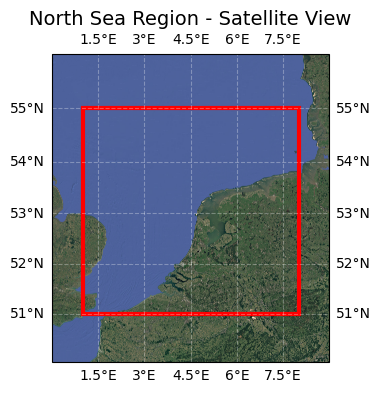

In [5]:
BBOX = [1.0, 51.0, 8.0, 55.0]

imagery = cimgt.GoogleTiles(style='satellite')

fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection=imagery.crs)

margin = 1.0
extent = [BBOX[0] - margin, BBOX[2] + margin, BBOX[1] - margin, BBOX[3] + margin]
ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.add_image(imagery, 10)

width = BBOX[2] - BBOX[0]
height = BBOX[3] - BBOX[1]

rect = patches.Rectangle(
    (BBOX[0], BBOX[1]), 
    width, 
    height, 
    linewidth=3, 
    edgecolor='red', 
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(rect)

gl = ax.gridlines(draw_labels=True, color='white', alpha=0.3, linestyle='--')
gl.top_labels = True
gl.right_labels = True
plt.title("North Sea Region - Satellite View", fontsize=14, color='black')
plt.show()

### Satellite Data Acquisition

Query the STAC API to retrieve Sentinel-1 Level-2 OCN products within the North Sea bounding box and filter them to keep only relevant scenes.

In [6]:
def search_stac_items(limit=100):
    search_url = f"{STAC_API_URL}/search"
    payload = {
        "collections": [COLLECTION_ID],
        "datetime": f"{START_DATE}/{END_DATE}",
        "bbox": BBOX,
        "limit": limit
    }
    print("Searching STAC API...")
    resp = requests.post(search_url, json=payload)
    resp.raise_for_status()
    features = resp.json().get('features', [])
    
    valid_items = []
    target_box = box(BBOX[0], BBOX[1], BBOX[2], BBOX[3])
    
    for item in features:
        item_bbox = item['bbox']
        item_geom = box(item_bbox[0], item_bbox[1], item_bbox[2], item_bbox[3])
        if item_geom.intersects(target_box):
            valid_items.append(item)
            
    print(f"Found {len(features)} raw items, {len(valid_items)} inside target BBOX.")
    return valid_items

all_items = search_stac_items(limit=800)

Searching STAC API...
Found 767 raw items, 767 inside target BBOX.


### Wind Field Visualization

Visualize sample wind fields by plotting wind speed contours and direction vectors to show the spatial patterns in the data.

Visualizing wind field items 1 to 4...


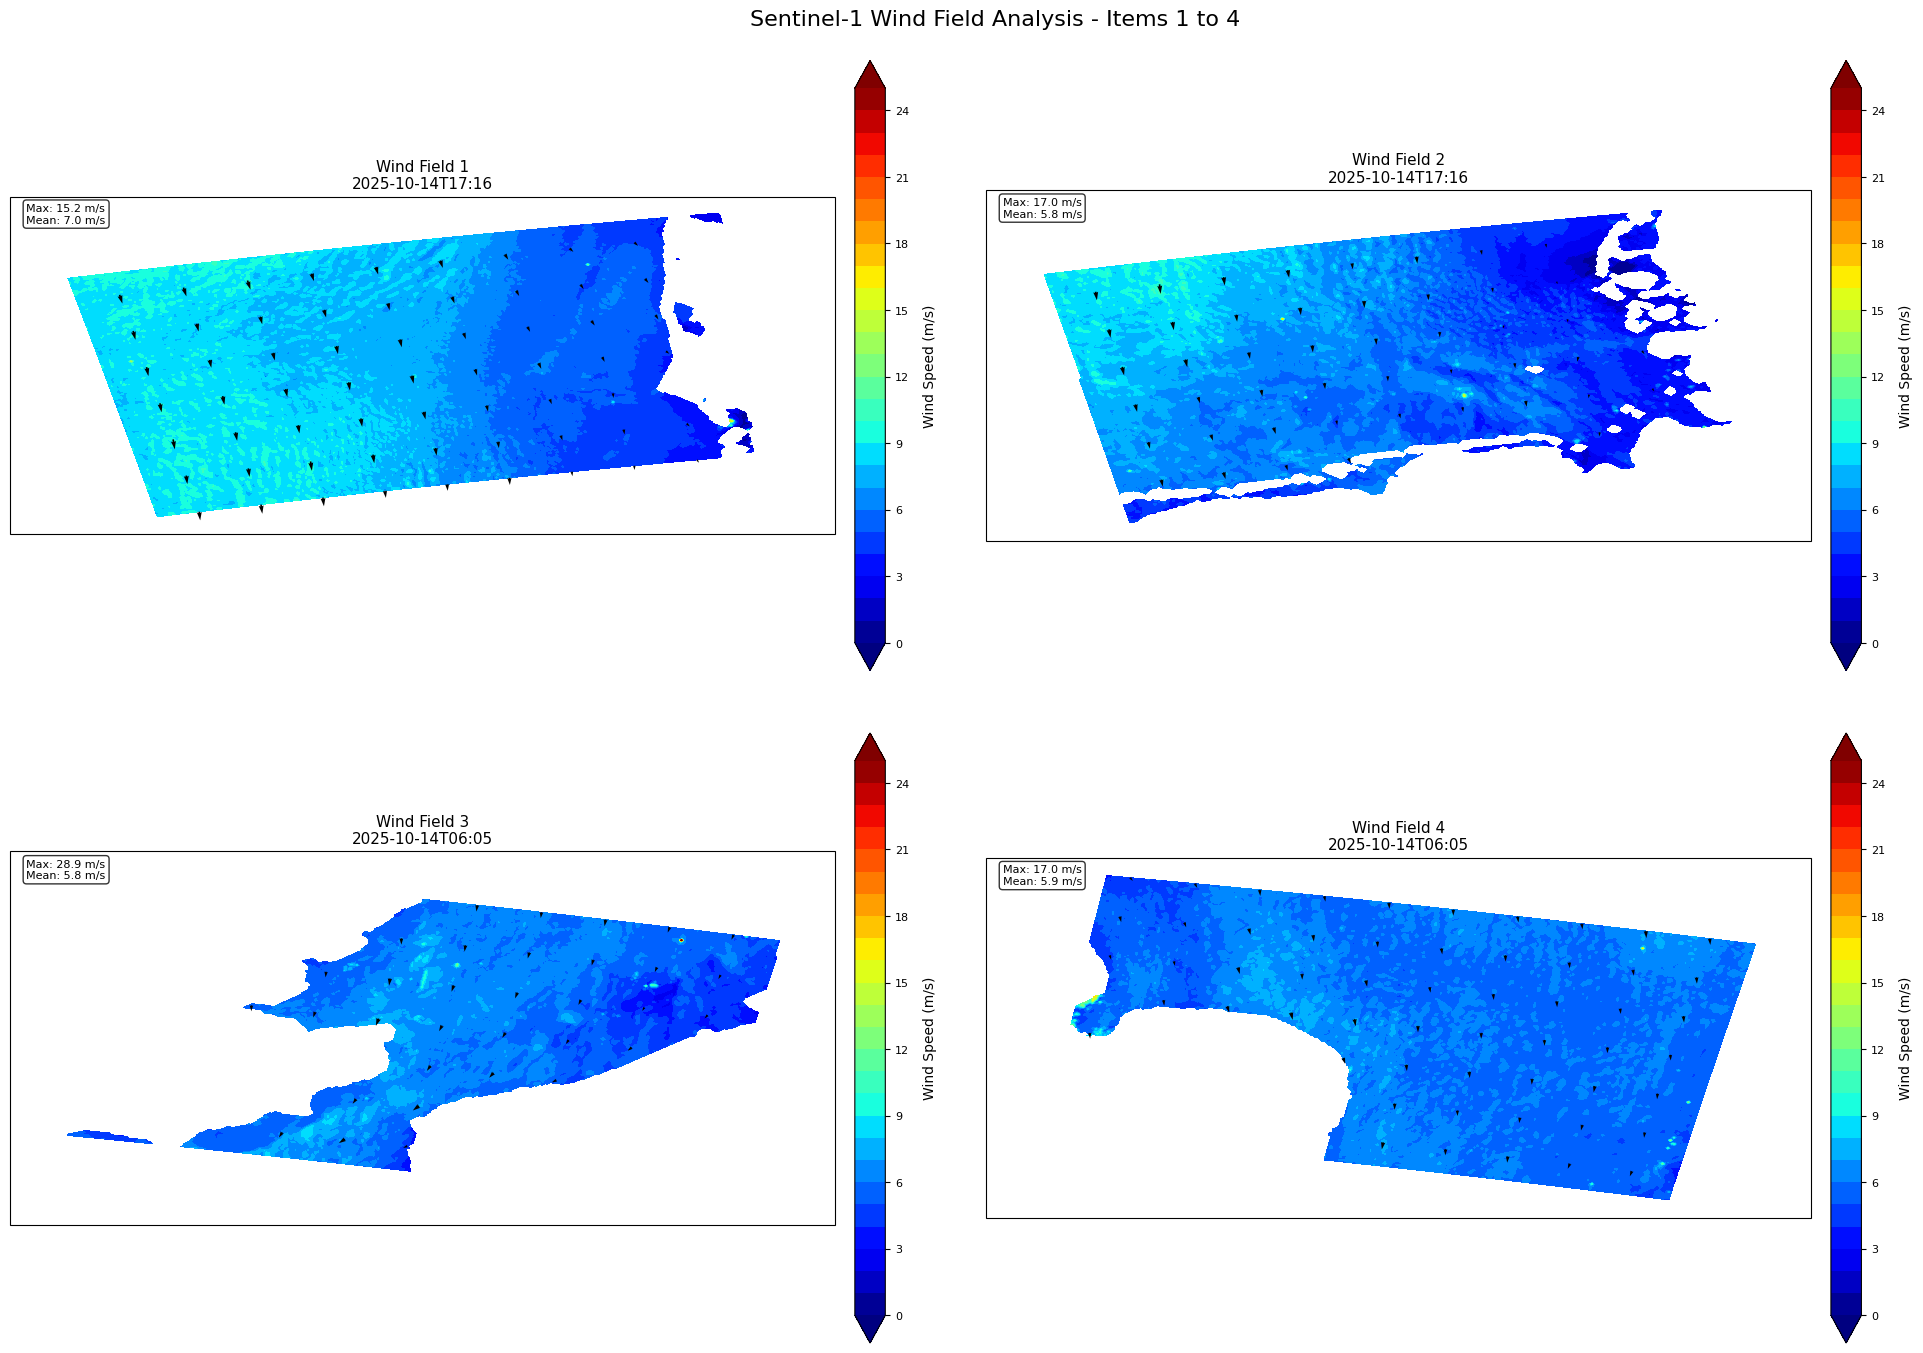

In [8]:
def open_ocn_zarr(item):
    assets = item.get('assets', {})
    owi_asset = assets.get('owi')
    if not owi_asset: 
        return None
        
    zarr_url = owi_asset['href']
    if '.zarr' in zarr_url:
        root_url, group_path = zarr_url.split('.zarr', 1)
        root_url += '.zarr'
        group_path = group_path.lstrip('/')
    else:
        root_url = zarr_url
        group_path = None

    try:
        if group_path:
            ds = xr.open_dataset(root_url, engine='zarr', chunks={}, group=group_path, consolidated=True)
        else:
            ds = xr.open_dataset(root_url, engine='zarr', chunks={}, consolidated=True)
        return ds
    except Exception as e:
        print(f"Error: {e}")
        return None

# Visualize the items
start_idx = 0
end_idx = 4
num_items_to_show = min(end_idx - start_idx, len(all_items) - start_idx)
print(f"Visualizing wind field items {start_idx+1} to {start_idx+num_items_to_show}...")

if all_items and len(all_items) > start_idx:
    # Create a figure with subplots for multiple items
    fig = plt.figure(figsize=(20, 15))
    
    if num_items_to_show <= 4:
        rows, cols = 2, 2
    elif num_items_to_show <= 6:
        rows, cols = 2, 3
    elif num_items_to_show <= 9:
        rows, cols = 3, 3
    elif num_items_to_show <= 12:
        rows, cols = 3, 4
    else:
        rows, cols = 4, 4
    
    for i in range(num_items_to_show):
        idx = start_idx + i
        item = all_items[idx]
        ds = open_ocn_zarr(item)
        
        if ds:
            ax = fig.add_subplot(rows, cols, i + 1, projection=ccrs.PlateCarree())
            
            # Determine the correct variable names
            ws_var = 'wind_speed' if 'wind_speed' in ds else 'owiWindSpeed'
            wd_var = 'wind_direction' if 'wind_direction' in ds else 'owiWindDirection'
            
            # Extract the data
            wind_speed = ds[ws_var].values
            wind_dir = ds[wd_var].values
            lon = ds.lon.values if 'lon' in ds else ds.longitude.values
            lat = ds.lat.values if 'lat' in ds else ds.latitude.values
            
            # Plot Wind Speed using Contourf
            c_inv = np.linspace(0, 25, 26) # 0 to 25 m/s
            
            contour = plt.contourf(lon, lat, wind_speed, c_inv, 
                                 transform=ccrs.PlateCarree(), 
                                 cmap=plt.cm.jet, 
                                 extend='both')
            
            # Add Colorbar
            cb = plt.colorbar(contour, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
            cb.set_label('Wind Speed (m/s)', size=10, rotation=90, labelpad=10)
            cb.ax.tick_params(labelsize=8)
            
            # Plot Wind Vectors (Quiver)
            skip = 25 
            rad = np.radians(wind_dir)
            u = -wind_speed * np.sin(rad)
            v = -wind_speed * np.cos(rad)
            
            ax.quiver(lon[::skip, ::skip], lat[::skip, ::skip], 
                     u[::skip, ::skip], v[::skip, ::skip], 
                     transform=ccrs.PlateCarree(), 
                     color='black', 
                     scale=800,  
                     width=0.002,
                     headwidth=3)
            
            # Get datetime for title
            datetime_str = item['properties']['datetime']
            ax.set_title(f"Wind Field {idx + 1}\n{datetime_str[:16]}", size=11)
            
            # Add wind statistics as text
            max_wind = np.nanmax(wind_speed)
            mean_wind = np.nanmean(wind_speed)
            ax.text(0.02, 0.98, f'Max: {max_wind:.1f} m/s\nMean: {mean_wind:.1f} m/s', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=8)
        else:
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.text(0.5, 0.5, f'Item {idx + 1}\nData not available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"Wind Field {idx + 1} - No Data")
    
    plt.suptitle(f'Sentinel-1 Wind Field Analysis - Items {start_idx+1} to {start_idx+num_items_to_show}', size=16, y=0.95)
    plt.tight_layout()
    plt.show()

## Data Preprocessing for Machine Learning

Convert wind fields into 128×128 normalized images, handle missing values, and assign labels based on mean wind speed for model training.

In [9]:
MAX_WIND = 25.0  # for normalization & contour levels

def extract_wind_sample(item, img_size=128):
    """Open OWI, get wind_speed map, resize, normalize, and label by mean speed."""
    ds = open_ocn_zarr(item)
    if ds is None:
        return None, None
    
    # Pick variable name
    ws_var = 'wind_speed' if 'wind_speed' in ds else 'owiWindSpeed'
    if ws_var not in ds:
        print(f"No wind speed var in item {item['id']}")
        return None, None
    
    wind_speed = ds[ws_var].values.astype(np.float32)
    
    # Take the first slice that looks 2D
    ws_2d = None
    if wind_speed.ndim == 2:
        ws_2d = wind_speed
    elif wind_speed.ndim == 3:
        ws_2d = wind_speed[0, :, :]
    elif wind_speed.ndim == 4:
        ws_2d = wind_speed[0, 0, :, :]
    else:
        print(f"Unexpected shape {wind_speed.shape} for item {item['id']}")
        return None, None
    
    # Remove NaNs
    ws_2d = np.where(np.isfinite(ws_2d), ws_2d, np.nan)
    if np.all(np.isnan(ws_2d)):
        print(f"All NaNs in item {item['id']}")
        return None, None
    
    # Simple fill: replace NaNs with mean of valid pixels
    mean_val = np.nanmean(ws_2d)
    ws_2d = np.where(np.isnan(ws_2d), mean_val, ws_2d)
    
    # Compute mean speed for label
    mean_speed = float(np.mean(ws_2d))
    
    # Label definition (you can tweak thresholds)
    if mean_speed <= 5.0:
        label = 0  # calm
    elif mean_speed <= 12.0:
        label = 1  # moderate
    else:
        label = 2  # high wind / storm
    
    # Resize to fixed size (IMG_SIZE x IMG_SIZE)
    ws_resized = resize(ws_2d, (img_size, img_size), mode='reflect', anti_aliasing=True)
    
    # Normalize to [0, 1]
    ws_norm = np.clip(ws_resized / MAX_WIND, 0.0, 1.0)
    
    # Add channel dimension -> (1, H, W)
    ws_norm = ws_norm[np.newaxis, :, :].astype(np.float32)
    
    return ws_norm, label

### Dataset Creation

Process all satellite items into input images (X) and wind class labels (y) to form the dataset, then display its shape and class distribution.

In [10]:
X_list = []
y_list = []

print("Building dataset from items...")
for item in all_items:
    img, label = extract_wind_sample(item, img_size=IMG_SIZE)
    if img is not None:
        X_list.append(img)
        y_list.append(label)

X = np.stack(X_list, axis=0)  # shape: (N, 1, H, W)
y = np.array(y_list, dtype=np.int64)

print("Dataset shapes:", X.shape, y.shape)
print("Class counts:", np.bincount(y))

Building dataset from items...
Dataset shapes: (767, 1, 128, 128) (767,)
Class counts: [231 511  25]


### PyTorch Dataset and Data Loaders

Convert the data into PyTorch Dataset and DataLoader objects, and split it into training and validation sets for model training.

In [11]:
class WindSceneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = WindSceneDataset(X_train, y_train)
val_ds   = WindSceneDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

### Convolutional Neural Network Model

Define a CNN with convolution, pooling, and fully connected layers to learn wind patterns and classify each sample into one of three wind categories.

In [12]:
class WindCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 -> 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 -> 16
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = WindCNN(num_classes=3).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Model Training

Train the CNN using the Adam optimizer and cross-entropy loss, while tracking training progress and validating performance each epoch.

In [13]:
EPOCHS = 4

print(f"Starting Training on {DEVICE}...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    
    for batch_x, batch_y in train_loop:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
        
        train_loop.set_postfix(loss=loss.item())
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    
    # Calculate averages
    avg_train_loss = train_loss / len(train_ds)
    avg_val_loss = val_loss / len(val_ds)
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.3f}")

Starting Training on cpu...


Epoch 1/4 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/4 | Train Loss: 0.6011 | Val Loss: 0.2148 | Val Acc: 0.948


Epoch 2/4 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/4 | Train Loss: 0.1701 | Val Loss: 0.1694 | Val Acc: 0.929


Epoch 3/4 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/4 | Train Loss: 0.1353 | Val Loss: 0.0705 | Val Acc: 0.974


Epoch 4/4 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/4 | Train Loss: 0.0718 | Val Loss: 0.1319 | Val Acc: 0.948


## Model Prediction and Visualization

Use the trained CNN to predict wind classes and visualize each wind field with contours, vectors, confidence scores, and basic statistics.

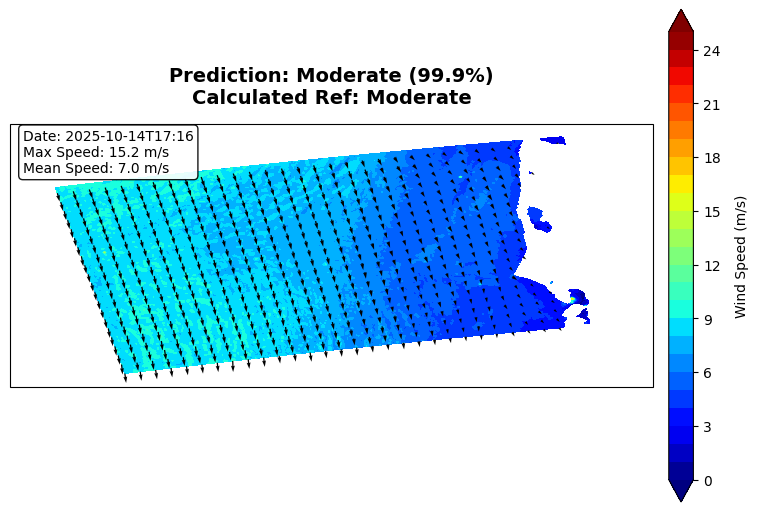

Item ID: S1C_IW_OCN__2SDV_20251014T171659_20251014T171724_004561_00905C_85D4
Probabilities: {'Calm': np.float32(0.0), 'Moderate': np.float32(0.999), 'High wind': np.float32(0.001)}


In [ ]:
def predict_and_display(item, model):
    model.eval()
    img_tensor, calculated_label = extract_wind_sample(item, img_size=IMG_SIZE)
    
    if img_tensor is None:
        print("No valid data for this item.")
        return

    x = torch.from_numpy(img_tensor).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))
    
    class_names = ['Calm', 'Moderate', 'High wind']
    prediction_text = class_names[pred_class]
    confidence = probs[pred_class]

    # Data Fetching
    ds = open_ocn_zarr(item)
    if ds is None:
        print("Could not open OCN for plotting.")
        return

    ws_var = 'wind_speed' if 'wind_speed' in ds else 'owiWindSpeed'
    wd_var = 'wind_direction' if 'wind_direction' in ds else 'owiWindDirection'
    
    wind_speed = ds[ws_var].values
    wind_dir = ds[wd_var].values
    
    if wind_speed.ndim > 2:
        wind_speed = np.squeeze(wind_speed)
    if wind_dir.ndim > 2:
        wind_dir = np.squeeze(wind_dir)
        
    lon = ds.lon.values if 'lon' in ds else ds.longitude.values
    lat = ds.lat.values if 'lat' in ds else ds.latitude.values

    # Visulization
    ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection=ccrs.PlateCarree())
    
    # Plot Wind Speed Contours using JET
    c_inv = np.linspace(0, 25, 26) 
    contour = plt.contourf(lon, lat, wind_speed, c_inv, 
                         transform=ccrs.PlateCarree(), 
                         cmap=plt.cm.jet,
                         extend='both')
    
    # Colorbar
    cb = plt.colorbar(contour, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cb.set_label('Wind Speed (m/s)', size=10, rotation=90, labelpad=10)

    # Plot Wind Vectors
    rad = np.radians(wind_dir)
    u = -wind_speed * np.sin(rad)
    v = -wind_speed * np.cos(rad)

    skip = int(max(wind_speed.shape) / 30)
    if skip < 1:
        skip = 1

    ax.quiver(lon[::skip, ::skip], lat[::skip, ::skip],
             u[::skip, ::skip], v[::skip, ::skip],
             transform=ccrs.PlateCarree(),
             color='black',     # <--- Changed to black to contrast with Jet
             scale=600,
             width=0.002,
             headwidth=3)

    # Titles and Stats
    datetime_str = item['properties']['datetime']

    plt.title(f"Prediction: {prediction_text} ({confidence:.1%})\n"
              f"Calculated Ref: {class_names[calculated_label]}",
              fontsize=14, fontweight='bold', pad=15)
    
    stats_text = (f"Date: {datetime_str[:16]}\n"
                  f"Max Speed: {np.nanmax(wind_speed):.1f} m/s\n"
                  f"Mean Speed: {np.nanmean(wind_speed):.1f} m/s")
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           fontsize=10)

    plt.show()
    
    print(f"Item ID: {item['id']}")
    class_names = ['Calm', 'Moderate', 'High wind']
    print("Probabilities:", dict(zip(class_names, probs.round(3))))

## Model Saving and Sample Testing

Save the trained CNN for future use, then test it on a few random wind field samples to visualize predictions, compare them with ground truth, and assess model performance.

Model saved as 'wind_cnn_model.pth'

 Sample Prediction

--- Sample 1 ---


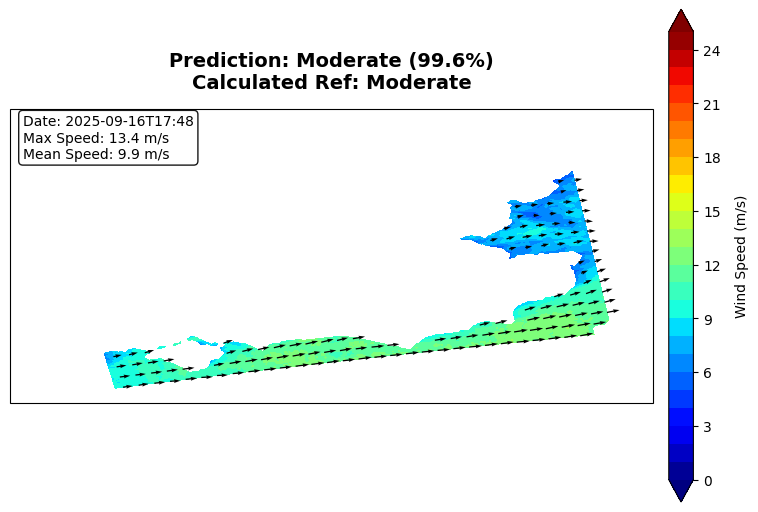

Item ID: S1C_IW_OCN__2SDV_20250916T174841_20250916T174906_004153_0083F6_D03F
Probabilities: {'Calm': np.float32(0.0), 'Moderate': np.float32(0.996), 'High wind': np.float32(0.003)}

--- Sample 2 ---


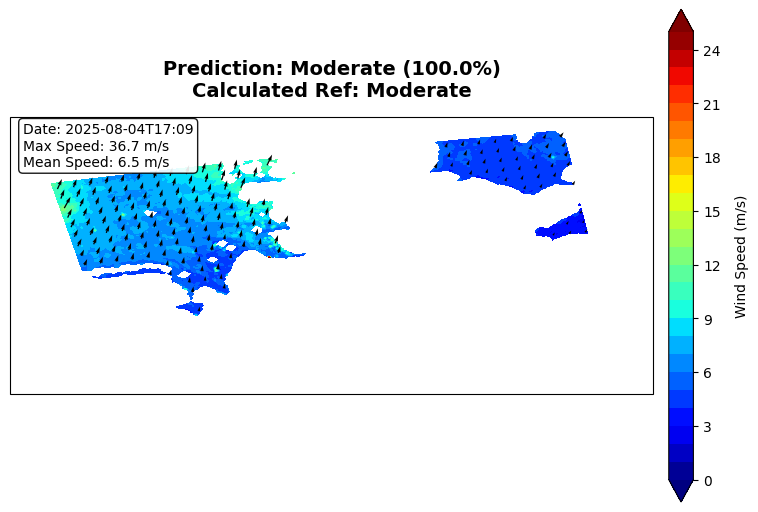

Item ID: S1A_IW_OCN__2SDV_20250804T170917_20250804T170942_060389_078193_F784
Probabilities: {'Calm': np.float32(0.0), 'Moderate': np.float32(1.0), 'High wind': np.float32(0.0)}

--- Sample 3 ---


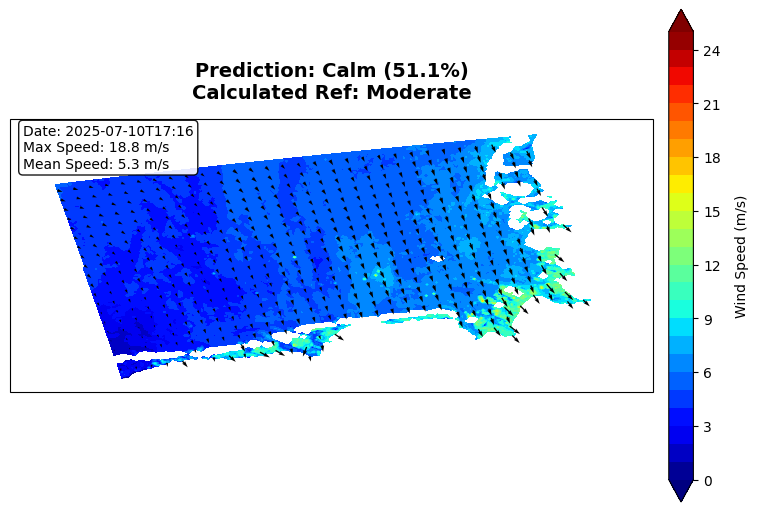

Item ID: S1C_IW_OCN__2SDV_20250710T171631_20250710T171656_003161_006672_FC86
Probabilities: {'Calm': np.float32(0.511), 'Moderate': np.float32(0.486), 'High wind': np.float32(0.003)}


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'wind_cnn_model.pth')
print("Model saved as 'wind_cnn_model.pth'")

# Test the model on a few random samples
print("\n Sample Prediction")
test_indices = random.sample(range(len(all_items)), 3)

for i, idx in enumerate(test_indices):
    print(f"\n--- Sample {i+1} ---")
    item = all_items[idx]
    # This function now handles:
    # 1. Prediction
    # 2. Calculating actual stats
    # 3. Generating the map visualization
    # 4. Printing probabilities
    predict_and_display(item, model)

<hr>

## Conclusion

This notebook walked through a complete workflow for classifying ocean wind conditions using Sentinel-1 Level-2 OCN data. By accessing wind fields through the EOPF STAC API, preprocessing them into consistent image patches, and training a CNN model, we demonstrated how satellite-based wind information can be turned into a practical classification system.

The model successfully separated Calm, Moderate, and High wind regimes and produced visual outputs that combine predictions with underlying wind speed and direction patterns. This workflow can be easily adapted to new regions, time periods, or extended with additional variables for more advanced ocean analysis.